## Project Reinforcement Learning 

Group 7 - Willem Huijzer, Joris Holshuijsen, Max Feucht


In [19]:
import gymnasium as gym
from gymnasium import spaces
import numpy as np
import time
import matplotlib.pyplot as plt
import torch 
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import random
from collections import deque
from mpl_toolkits import mplot3d
from matplotlib import cm
import pandas as pd
import seaborn as sns
from tqdm import tqdm

### Setting up the environment:

- 50kWh of usable capacity 
- 90% efficiency of the battery (both ways)
- The maximum power available is 25kW (both ways - pertains to charging and discharging. One hour, we charge and discharge 25kWh) 
- Prices are in MWh! --> Rescale
- Electricity is sold at the spot market price
- Electricity is bought at twice the price to pay for the transmission costs and various taxes.
- Only data up to the current time step available
- Day: 8am to 6pm
- Night: 6pm - 8am
- 50% of days, car is not available during the day and returns with 20kWh less
- Minimum capacity at 8am: 20kWh (if charge < 20kwH, charge from 7am to 8am)


### Open Questions:

- Intensity at which to sell or buy (Always 25kW, does it make sense to sell / buy less over a longer period of time)
- What reward to give when trying to charge / sell during the day when car is absent. Do we give a penalty for even trying or do we let it do whatever it wants?

In [20]:
# Load Data

def elongate(df):
    df_long = pd.wide_to_long(df, i = "PRICES", j = "hour", stubnames=["Hour"], sep = " ").reset_index()
    df_long.rename(columns={"Hour": "price", "PRICES": "date"}, inplace = True)
    df_long['datetime'] = pd.to_datetime(df_long['date']) + pd.to_timedelta(df_long['hour'], unit='h')
    df_long.sort_values(['datetime'], ascending=[True], inplace=True)
    df_long['price'] = df_long['price'].astype(float) / 1000 # Convert price per MWh to price per KWh
    return df_long

train = elongate(pd.read_excel('data/train.xlsx'))
val = elongate(pd.read_excel('data/validate.xlsx'))


In [31]:
import gym_env
env = gym.make('gym_env/BatteryGrid-v0')


In [22]:
class PriceIteration():
    
    def __init__(self, df, env, low_quantile = 0.25, high_quantile = 0.75, price_horizon = 96, verbose = False):
        self.df = df
        self.env = env
        self.low_quantile = low_quantile
        self.high_quantile = high_quantile
        self.price_horizon = price_horizon
        self.verbose = verbose
        
        
    
    def rule_iteration(self, iterations = 1000):
        """
        Iterate through data and take actions based on price quantiles as a function of the price horizon
        """
        
        self.data = self.df[:iterations]
        self.prices = np.array(self.data['price'])

        self.battery_charge = []
        self.rewards = []

        obs_dict = self.env.reset()        
        o,r,t,tensor = self.env.step(0)

        for i in range(len(self.data)):
            
            if o['prices'][-1] < np.quantile(o['prices'][-self.price_horizon:], self.low_quantile):
                action = 0
            elif o['prices'][-1] > np.quantile(o['prices'][-self.price_horizon:], self.low_quantile) and o['prices'][-1] < np.quantile(o['prices'][-self.price_horizon:], self.high_quantile):
                action = 5
            elif o['prices'][-1] >  np.quantile(o['prices'][-self.price_horizon:], self.high_quantile):
                action = 10
            else:
                action = np.random.randint(0,3)
            
            self.battery_charge.append(o['battery'])
            self.rewards.append(r)
            
            o,r,t,tensor = env.step(action)
            
            if t:
                break
        
    
    
    def agent_iteration(self, iterations = 1000, agent = None):
        """Function to iterate through data and take actions based on agent policy

        Args:
            iterations (int, optional): _description_. Defaults to 1000.
            agent (_type_, optional): _description_. Defaults to None.
        """
        
        assert agent is not None, "Agent must be defined"
        
        self.data = self.df[:iterations]
        self.prices = np.array(self.data['price'])

        self.battery_charge = []
        self.rewards = []
        self.actions = []

        obs = env.reset()        

        for i in range(len(self.data)):
            
            action = agent.choose_action(i, obs['tensor'], greedy = False)
            new_obs,r,t,info = env.step(action)
            
            obs = new_obs
            
            self.actions.append(action)
            self.battery_charge.append(obs['battery'])
            self.rewards.append(r)
                
            if t:
                break

    
    
    def normalize(self, data):
        """
        Helper function to normalize data
        """
        return ((data - np.min(data)) / (np.max(data) - np.min(data)))
    
    
    
    def normalize_data(self):
        """
        Normalizes data acquired from iteration
        """
        
        self.battery_charge = self.normalize(np.array(self.battery_charge))
        self.rewards = self.normalize(np.array(self.rewards))
        self.prices = self.normalize(np.array(self.data['price']))
        self.cumulative_reward = self.normalize(np.cumsum(self.rewards))
        
        
        
    def plot_all(self, cum = False, normalize = True):
        
        """ 
        Plots battery charge, reward, price, and cumulative reward (if cum = True) in one combined plot
        """
        
        plt.figure(figsize=(15,5))
        
        vars = [self.battery_charge, self.rewards, self.prices]
        var_names = ['Battery Charge', 'Reward', 'Price']
        
        if cum: 
            self.cumulative_reward = np.cumsum(self.rewards)
            vars.append(self.cumulative_reward)
            var_names.append('Cumulative Reward')
            
        for var in vars:
            if normalize:
                var = self.normalize(np.array(var))
            plt.plot(self.data['datetime'], var)
            
        plt.xticks(rotation=45)
        plt.legend(var_names)
        plt.show()
        
        
    def plot_single(self, normalize = True):
            
        """ 
        Plots battery charge, reward, price, and cumulative reward in single subplots
        """

        plt.figure(figsize=(15,10))
        self.cumulative_reward = np.cumsum(self.rewards)
        vars = [self.battery_charge, self.rewards, self.prices, self.cumulative_reward]
        var_names = ['Battery Charge', 'Reward', 'Price', 'Cumulative Reward']
        cols = ['blue', 'red', 'green', 'orange']
        
        for i, var in enumerate(vars):
            if normalize:
                var = self.normalize(np.array(var))
            plt.subplot(2,2,i+1)
            plt.plot(self.data['datetime'], var, color = cols[i])
            plt.title(var_names[i])
            plt.xticks(rotation=45)
            
            
        plt.show()
        
        
            
        

/Users/maxfeucht/anaconda3/envs/PRL/lib/python3.11/site-packages/gymnasium/utils/passive_env_checker.py:189: UserWarning: WARN: The result returned by `env.reset()` was not a tuple of the form `(obs, info)`, where `obs` is a observation and `info` is a dictionary containing additional information. Actual type: `<class 'dict'>`
  logger.warn(
/Users/maxfeucht/anaconda3/envs/PRL/lib/python3.11/site-packages/gymnasium/utils/passive_env_checker.py:213: DeprecationWarning: WARN: Core environment is written in old step API which returns one bool instead of two. It is recommended to rewrite the environment with new step API. 
  logger.deprecation(
/Users/maxfeucht/anaconda3/envs/PRL/lib/python3.11/site-packages/gymnasium/utils/passive_env_checker.py:131: UserWarning: WARN: The obs returned by the `step()` method was expecting a numpy array, actual type: <class 'numpy.float64'>
  logger.warn(
/Users/maxfeucht/anaconda3/envs/PRL/lib/python3.11/site-packages/gymnasium/spaces/box.py:240: UserWarn

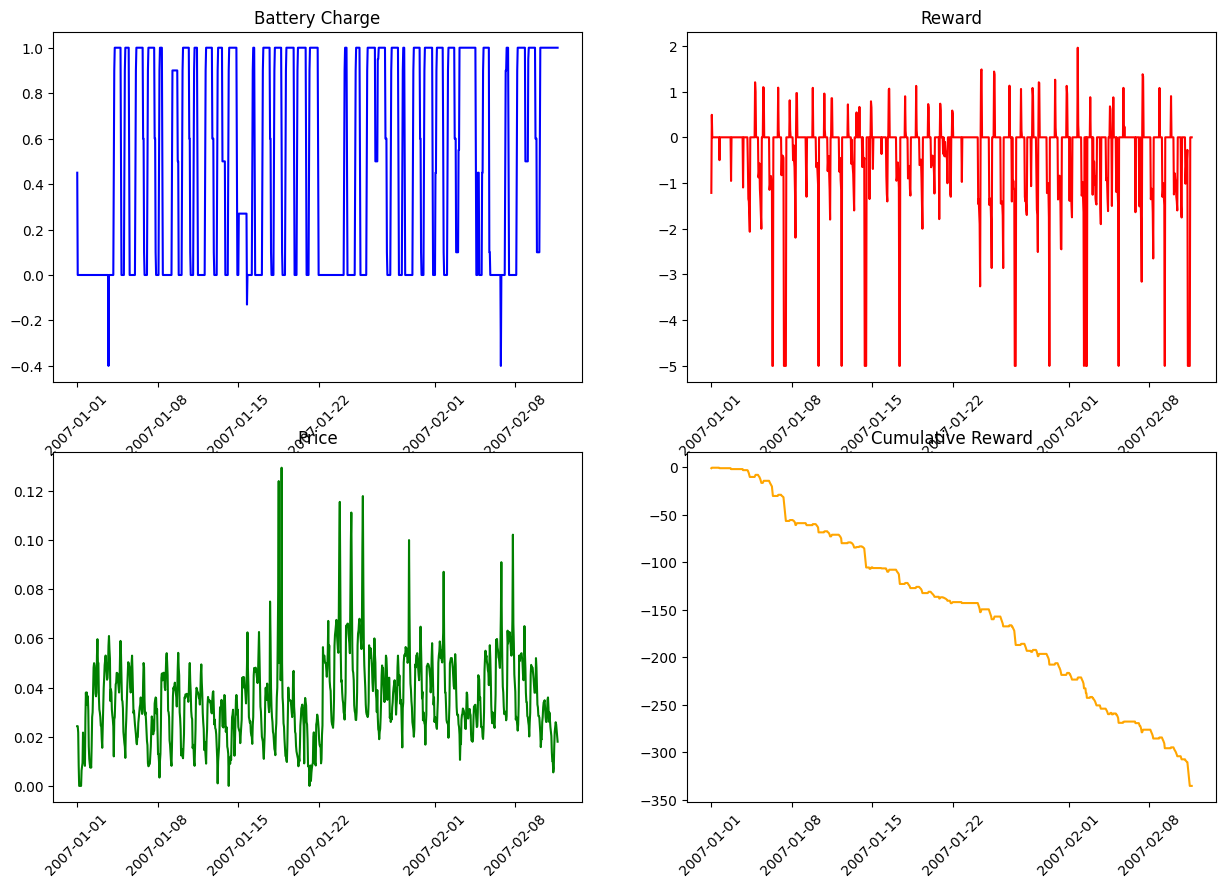

In [23]:
iterator = PriceIteration(train, env)
iterator.rule_iteration(iterations = 1000)
iterator.plot_single(normalize=False)#

In [24]:
## Questions for RL approach: 

# What is the state space? How far back do we need to look? Idea for now: For the first 96 time steps (4 days), we do nothing, until we gathered enough prices to make a decision. (Note: We will charge anyway ) Then, we look at the last 96 time steps and let the algorithm derive a strategy to act optimally based on that.
# Do we fill our replay buffer with random actions in the beginning?
# How do we handle the continous action space to update the output? We need to choose the max next action, but we can't do that with a continous action space. Think and inform about that. For now, we will use a discrete action space, evenly spaced.
# Important Decision: When and how do we normalize? Do we normalize once in the beginning, or do we normlaize every price history window separately? By doing so, we deprive the model of a "global" sense of price, although that might not be detrimental, as the price is mostly locally relevant. 

In [25]:
class DQN(nn.Module):
    
    def __init__(self, env, learning_rate, price_horizon = 96):
        
        '''
        Params:
        env = environment that the agent needs to play
        learning_rate = learning rate used in the update
        '''
        
        super(DQN,self).__init__()
        input_features = price_horizon + 1 + 1 + 1 + 1 #battery charge, price, presence, day, hour
        
        #Solution:
        self.linear1 = nn.Linear(input_features, 64)
        self.linear2 = nn.Linear(64, 64)
        self.linear3 = nn.Linear(64, 32)
        self.linear4 = nn.Linear(32, 11)
        
        self.leakyReLU = nn.LeakyReLU()
        self.sigmoid = nn.Sigmoid()
        self.softmax = nn.Softmax()
        
        #Here we use ADAM, but you could also think of other algorithms such as RMSprob
        self.optimizer = optim.Adam(self.parameters(), lr = learning_rate)
    
    
    
    def forward(self, x):
        
        '''
        Params:
        x = observation
        '''
        
        '''
        ToDo: 
        Write the forward pass! You can use any activation function that you want (ReLU, tanh)...
        Important: We want to output a linear activation function as we need the q-values associated with each action
    
        '''
        
        #Solution:
        x = self.leakyReLU(self.linear1(x))
        x = self.leakyReLU(self.linear2(x))
        x = self.leakyReLU(self.linear3(x))
        x = self.softmax(self.linear4(x)) # Softmax to get a probability distribution over the actions
        
        return x




class ExperienceReplay:
    
    def __init__(self, env, buffer_size, min_replay_size = 1000, seed = 123):
        
        '''
        Params:
        env = environment that the agent needs to play
        buffer_size = max number of transitions that the experience replay buffer can store
        min_replay_size = min number of (random) transitions that the replay buffer needs to have when initialized
        seed = seed for random number generator for reproducibility
        '''
        
        self.env = env
        self.min_replay_size = min_replay_size
        self.replay_buffer = deque(maxlen=buffer_size)
        self.device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
        
        
        #Initialize replay buffer with random transitions                
        obs = self.env.reset(seed=seed)
        
        for _ in range(self.min_replay_size):
            
            action = env.action_space.sample()
            new_obs,r,terminated,info = env.step(action)

            transition = (obs['tensor'], action, r, terminated, new_obs['tensor'])
            self.replay_buffer.append(transition)
            obs = new_obs
    
            if terminated:
                obs = env.reset(seed=seed)
              
          
    def add_data(self, data): 
        '''
        Params:
        data = relevant data of a transition, i.e. action, new_obs, reward, done
        '''
        self.replay_buffer.append(data)


    def sample(self, batch_size):
        
        '''
        Params:
        batch_size = number of transitions that will be sampled
        
        Returns:
        tensor of observations, actions, rewards, dones (boolean) and new_observations 
        '''
        
        transitions = random.sample(self.replay_buffer, batch_size)
        
        observations = np.asarray([t[0] for t in transitions])
        actions = np.asarray([t[1] for t in transitions])
        rewards = np.asarray([t[2] for t in transitions])
        dones = np.asarray([t[3] for t in transitions])
        new_observations = np.asarray([t[4] for t in transitions])
        
        #PyTorch needs these arrays as tensors!, don't forget to specify the device! (cpu/GPU) 
        observations_t = torch.as_tensor(observations, dtype = torch.float32, device=self.device)
        actions_t = torch.as_tensor(actions, dtype = torch.int64, device=self.device).unsqueeze(-1)
        rewards_t = torch.as_tensor(rewards, dtype = torch.float32, device=self.device).unsqueeze(-1)
        terminated_t = torch.as_tensor(dones, dtype = torch.float32, device=self.device).unsqueeze(-1)
        new_observations_t = torch.as_tensor(new_observations, dtype = torch.float32, device=self.device)
        
        return observations_t, actions_t, rewards_t, terminated_t, new_observations_t
    


In [26]:
class DDQNAgent:
    
    def __init__(self, env_name, df, device, epsilon_decay, 
                 epsilon_start, epsilon_end, discount_rate, lr, buffer_size, price_horizon = 96, seed = 123):
        """
        Params:
        env = environment that the agent needs to play
        device = set up to run CUDA operations
        epsilon_decay = Decay period until epsilon start -> epsilon end
        epsilon_start = starting value for the epsilon value
        epsilon_end = ending value for the epsilon value
        discount_rate = discount rate for future rewards
        lr = learning rate
        buffer_size = max number of transitions that the experience replay buffer can store
        seed = seed for random number generator for reproducibility
        """
        
        self.env_name = env_name
        self.env = gym.make(self.env_name)
        self.env.setup(df, price_horizon = price_horizon)
        self.device = device
        self.epsilon_decay = epsilon_decay
        self.epsilon_start = epsilon_start
        self.epsilon_end = epsilon_end
        self.discount_rate = discount_rate
        self.learning_rate = lr
        self.buffer_size = buffer_size
        
        #self.replay_memory = ExperienceReplay(self.env, self.buffer_size, seed = seed)
        self.index = 0
        self.dqn_predict = DQN(self.env, self.learning_rate, price_horizon=price_horizon).to(self.device)
        self.dqn_target = DQN(self.env, self.learning_rate, price_horizon=price_horizon).to(self.device)
        self.replay_memory = ExperienceReplay(self.env, self.buffer_size, seed = seed)
        
        
        
    def choose_action(self, step, observation, greedy = False):
        
        """Function to choose an action based on the epsilon-greedy policy

        Input:
            step: current iteration step for epsilon decay
            observation: current observation
            greedy: boolean that indicates whether the action should be chosen greedily or not
        
        Returns:
            action: action that the agent takes
        """
        
        epsilon = np.interp(step, [0, self.epsilon_decay], [self.epsilon_start, self.epsilon_end])

        random_sample = random.random()
    
        if (random_sample <= epsilon) and not greedy:
            action = self.env.action_space.sample()
        
        else:
            #Greedy action
            obs_t = torch.as_tensor(observation, dtype = torch.float32, device=self.device)
            q_values = self.dqn_predict(obs_t)
        
            #max_q_index = torch.argmax(q_values, dim = 1)[0]
            max_q_index = torch.argmax(q_values)
    
            action = max_q_index.detach().item()
        
        return action
    
    
    
    def tensorize(self, obs, new_obs, action, reward, done):

        obs_t = torch.as_tensor(obs, dtype = torch.float32, device=self.device)
        new_obs_t = torch.as_tensor(new_obs, dtype = torch.float32, device=self.device)
        action_t = torch.as_tensor(action, dtype = torch.long, device=self.device)
        reward_t = torch.as_tensor(reward, dtype = torch.float32, device=self.device)
        done_t = torch.as_tensor(done, dtype = torch.float32, device=self.device)
        
        return obs_t, new_obs_t, action_t, reward_t, done_t



    def DQNstep(self):
        """
        Function that switches the DQN from the predictDQN to the targetDQN after 1000 steps
        """
        self.index += 1
        
        if self.index == 1000:
            self.dqn_target.load_state_dict(self.dqn_predict.state_dict())
            self.index = 0
        
        
    def optimize(self, batch_size):
            
        """
        Function that optimizes the DQN based on predicted q-values for the present and the next state, along with the reward received
        
        Params: 
        new_obs = new observation
        obs = old observation
        action = action taken
        reward = reward received
        done = boolean that indicates whether the episode is done or not
        
        Returns:
        loss = loss of the DQN
        """
        
        # Sample from replay buffer
        
        obs, actions, rewards, terminateds, new_obs = self.replay_memory.sample(batch_size)
        #obs_t, new_obs_t, action_t, reward_t, done_t = self.tensorize(obs, new_obs, action, reward, done)

        # Compute Loss: 
        # First compute DQN output for current state        
        q_values = self.dqn_predict(obs) #Predict q-values for the current state
        action_q_values = torch.gather(input=q_values, dim=1, index=actions) # Select the q-value for the action that was taken
        
        # Then: Compute DQN output for next state, and build the targets based on reward and the max q-value of the next state 
        target_q_values = self.dqn_target(new_obs) # Predict q-values for the next state
        max_target_q_values = target_q_values.max(dim=1, keepdim=True)[0] # Select the max q-value of the next state
        targets = rewards + self.discount_rate * (1-terminateds) * max_target_q_values # Compute the target q-value based on the reward and the max q-value of the next state
        
        #Loss
        loss = F.smooth_l1_loss(action_q_values, targets.detach()) #Compute the loss between the predicted q-value for the action taken and the target q-value based on the next observation
        
        #Gradient descent
        self.dqn_predict.optimizer.zero_grad()
        loss.backward()
        self.dqn_predict.optimizer.step()
        
        #Switch DQN step
        self.DQNstep()
        
        return loss.item()

In [27]:
def train_DQN(rep = 1000, batch_size = 32, gamma = 0.99, epsilon = 1, epsilon_decay = 0.999, epsilon_min = 0.01, learning_rate = 0.00001, price_horizon = 96, verbose = True):

    """
    Iterate through data and take actions based on DQN predictions, and update DQN based on rewards and next state Q values
    """
    
    #Initialize DQN
    agent = DDQNAgent(env_name = 'gym_env/BatteryGrid-v0', device = 'cpu', epsilon_decay = epsilon_decay, epsilon_start = epsilon, epsilon_end = epsilon_min, discount_rate = gamma, lr = learning_rate, buffer_size = 10000)
        
    obs = env.reset()

    episode_reward = 0
    episode_loss = 0
    
    for i in range(rep):
        
        action = agent.choose_action(i, obs, greedy = True)
        new_obs,r,t,info = env.step(action)
        episode_reward += r
        
        #Update DQN
        loss = agent.optimize(obs, new_obs, action, r, t)
        episode_loss += loss
        
        obs = new_obs
        
        if t:
            obs = env.reset()
            
            if i % 100 == 0 and verbose:
                print('Episode: ', i, 'Reward: ', episode_reward, 'Loss: ', episode_loss)
            

In [32]:
rep = 1000000
batch_size = 32
gamma = 0.99
epsilon = 0.8
epsilon_decay = 99999
epsilon_min = 0.01
learning_rate = 0.001
price_horizon = 12
verbose = True

# Initialize Environment
env.setup(train, price_horizon=price_horizon)

#Initialize DQN
agent = DDQNAgent(env_name = 'gym_env/BatteryGrid-v0', df = train, device = 'cpu', epsilon_decay = epsilon_decay, epsilon_start = epsilon, epsilon_end = epsilon_min, discount_rate = gamma, lr = learning_rate, buffer_size = 10000, price_horizon = price_horizon)
    
obs = env.reset()

episode_reward = 0
episode_loss = 0
episode_counter = 0

for i in tqdm(range(rep)):
    
    action = agent.choose_action(i, obs['tensor'], greedy = False)
    new_obs,r,t,info = env.step(action)

    # Fill replay buffer - THIS IS THE ONLY THING WE DO WITH THE CURRENT OBSERVATION - LEARNING IS FULLY PERFORMED FROM THE REPLAY BUFFER
    agent.replay_memory.add_data((obs['tensor'], action, r, t, new_obs['tensor']))
    
    #Update DQN
    loss = agent.optimize(batch_size)
    
    # Update values
    episode_reward += r
    episode_loss += loss
    
    # New observation
    obs = new_obs
    
    if t:
        obs = env.reset()
        episode_counter += 1
        print('Episode ', episode_counter, 'Reward: ', episode_reward, 'Loss: ', episode_loss)
        episode_loss = 0
        episode_reward = 0
            

  3%|▎         | 26350/1000000 [00:48<42:47, 379.17it/s]

Episode  1 Reward:  -9559.769310999984 Loss:  8736.36204993911


  5%|▌         | 52703/1000000 [01:39<27:30, 573.84it/s]

Episode  2 Reward:  -6876.578216500009 Loss:  5888.218516291585


  8%|▊         | 78970/1000000 [02:29<27:20, 561.52it/s]  

Episode  3 Reward:  -4022.6567149999983 Loss:  3438.8646205656696


 11%|█         | 105255/1000000 [03:20<30:00, 496.88it/s] 

Episode  4 Reward:  -1404.4336830000013 Loss:  1345.2087363533465


 13%|█▎        | 131577/1000000 [04:13<33:17, 434.74it/s]

Episode  5 Reward:  -400.6047994999999 Loss:  328.2967273772065


 16%|█▌        | 157891/1000000 [05:05<30:28, 460.46it/s]

Episode  6 Reward:  -365.65949099999995 Loss:  238.86456030278032


 18%|█▊        | 184210/1000000 [05:55<28:29, 477.17it/s]

Episode  7 Reward:  -469.8946655000001 Loss:  315.21631040942793


 21%|██        | 210463/1000000 [06:48<33:59, 387.07it/s]

Episode  8 Reward:  -463.59646800000013 Loss:  309.1432818898038


 24%|██▎       | 236798/1000000 [07:55<35:53, 354.46it/s]  

Episode  9 Reward:  -467.64057999999955 Loss:  272.3477991504369


 26%|██▋       | 263142/1000000 [08:50<22:26, 547.05it/s]  

Episode  10 Reward:  -495.5571305000001 Loss:  295.81571022494427


 29%|██▉       | 289420/1000000 [09:40<24:00, 493.37it/s]

Episode  11 Reward:  -528.3339960000002 Loss:  359.4847894487093


 32%|███▏      | 315735/1000000 [10:38<24:10, 471.81it/s]

Episode  12 Reward:  -492.57845799999984 Loss:  358.6654878051313


 34%|███▍      | 342016/1000000 [11:30<23:10, 473.23it/s]

Episode  13 Reward:  -499.66053299999976 Loss:  335.22357968002234


 37%|███▋      | 368355/1000000 [12:14<16:56, 621.48it/s]

Episode  14 Reward:  -539.0800999999999 Loss:  341.4448852539872


 39%|███▉      | 394676/1000000 [12:58<16:00, 630.53it/s]

Episode  15 Reward:  -431.53201999999993 Loss:  275.5746827653684


 42%|████▏     | 420980/1000000 [13:42<15:19, 629.80it/s]

Episode  16 Reward:  -510.08080099999984 Loss:  320.63385851112525


 45%|████▍     | 447280/1000000 [14:24<14:32, 633.74it/s]

Episode  17 Reward:  -466.1778319999999 Loss:  319.09313320979436


 47%|████▋     | 473565/1000000 [15:08<14:54, 588.61it/s]

Episode  18 Reward:  -460.02772100000016 Loss:  300.55019070045


 50%|████▉     | 499834/1000000 [15:51<14:01, 594.24it/s]

Episode  19 Reward:  -491.5089780000001 Loss:  340.4625376262138


 53%|█████▎    | 526126/1000000 [16:33<13:41, 577.18it/s]

Episode  20 Reward:  -392.61285000000026 Loss:  245.0523765745238


 55%|█████▌    | 552476/1000000 [17:19<11:41, 637.91it/s]

Episode  21 Reward:  -525.9756415 Loss:  375.67357536977215


 58%|█████▊    | 578744/1000000 [18:02<16:24, 428.06it/s]

Episode  22 Reward:  -494.5820920000001 Loss:  374.4492812217668


 61%|██████    | 605100/1000000 [18:45<10:29, 627.25it/s]

Episode  23 Reward:  -457.2280149999998 Loss:  337.32023314249227


 63%|██████▎   | 631367/1000000 [19:28<09:35, 640.54it/s]

Episode  24 Reward:  -501.87907149999984 Loss:  302.7871609713152


 66%|██████▌   | 657690/1000000 [20:11<09:01, 632.43it/s]

Episode  25 Reward:  -371.0451499999999 Loss:  283.56565398138537


 68%|██████▊   | 684004/1000000 [20:53<08:15, 637.57it/s]

Episode  26 Reward:  -460.18010600000036 Loss:  320.3780363098781


 71%|███████   | 710316/1000000 [21:37<08:19, 580.13it/s]

Episode  27 Reward:  -447.3585044999999 Loss:  301.2472999333504


 74%|███████▎  | 736622/1000000 [22:22<06:54, 634.89it/s]

Episode  28 Reward:  -417.4964735 Loss:  271.664698521633


 76%|███████▋  | 762888/1000000 [23:06<06:16, 629.79it/s]

Episode  29 Reward:  -580.5083585000001 Loss:  396.3432770004915


 79%|███████▉  | 789234/1000000 [23:48<05:33, 632.23it/s]

Episode  30 Reward:  -429.3785605000004 Loss:  290.59701381361447


 82%|████████▏ | 815442/1000000 [24:31<06:15, 491.41it/s]

Episode  31 Reward:  -454.4756090000001 Loss:  291.109741428058


 84%|████████▍ | 841813/1000000 [25:14<05:12, 506.33it/s]

Episode  32 Reward:  -437.57871100000006 Loss:  303.79345394648317


 87%|████████▋ | 868099/1000000 [25:57<03:52, 568.01it/s]

Episode  33 Reward:  -568.3796450000001 Loss:  358.4553573256576


 89%|████████▉ | 894408/1000000 [26:41<02:46, 634.29it/s]

Episode  34 Reward:  -430.61708999999985 Loss:  266.89962739001203


 92%|█████████▏| 920743/1000000 [27:24<02:19, 570.04it/s]

Episode  35 Reward:  -530.7362354999997 Loss:  333.30109568415173


 95%|█████████▍| 947025/1000000 [28:10<01:29, 593.01it/s]

Episode  36 Reward:  -514.8698840000002 Loss:  386.6821177601205


 97%|█████████▋| 973357/1000000 [28:52<00:42, 626.48it/s]

Episode  37 Reward:  -480.41317799999996 Loss:  330.99543284290394


100%|█████████▉| 999657/1000000 [29:36<00:00, 635.30it/s]

Episode  38 Reward:  -489.1396440000007 Loss:  293.96960146133415


100%|██████████| 1000000/1000000 [29:36<00:00, 562.84it/s]


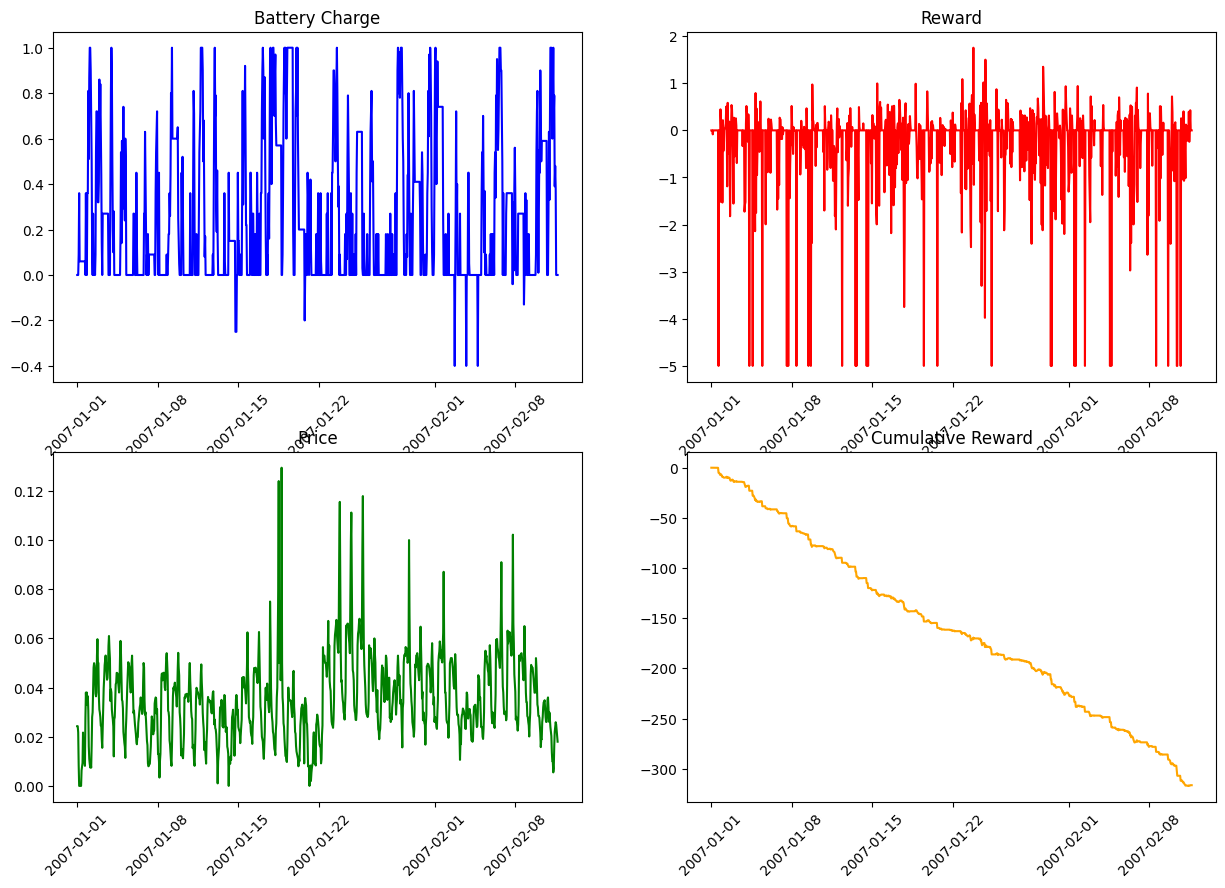

In [35]:
iterator = PriceIteration(train, env)
iterator.agent_iteration(agent = agent, iterations = 1000)
iterator.plot_single(normalize=False)

In [ ]:
# Reward Shaping:

# when rewards are not sparse, a measure of the uncertainty on
# the value function can be used to guide exploration.



# Replay Buffer:

# Problem: Our RL problem is a sequential one with a fixed starting point and a fixed order where to move. Does this affect the validity of s,a,r,s' for the replay buffer?


In [ ]:
# Feature Engineering: 

# ⁠Gradient of curve 
# Value of to same date last year if available 
# ⁠Moving average on different scale
# ⁠⁠Moving standard deviation  on different scales 
# ⁠⁠Season
# ⁠Day of week
# ⁠⁠Month
# Average historic hourly price
# Hardcoded price boundary (sell when price at previous timestep above threshold, buy when price at previous timestep is below threshold) - this can be a dynamic boundary (per month, per day, …) or a hard boundary 


In [ ]:
import torch
import torch.nn as nn
from torch.nn.utils import weight_norm
import torch.optim as optim
import pickle
import pandas as pd
import numpy as np
import math
from sklearn.metrics import f1_score
import matplotlib.pyplot as plt


class Chomp1d(nn.Module):
    def __init__(self, chomp_size):
        super(Chomp1d, self).__init__()
        self.chomp_size = chomp_size

    def forward(self, x):
        return x[:, :, :-self.chomp_size].contiguous()


class TemporalBlock(nn.Module):
    def __init__(self, n_inputs, n_outputs, kernel_size, stride, dilation, padding, dropout=0.2):
        super(TemporalBlock, self).__init__()
        self.conv1 = weight_norm(nn.Conv1d(n_inputs, n_outputs, kernel_size,
                                           stride=stride, padding=padding, dilation=dilation))
        self.chomp1 = Chomp1d(padding)
        self.relu1 = nn.ReLU()
        self.dropout1 = nn.Dropout(dropout)

        self.conv2 = weight_norm(nn.Conv1d(n_outputs, n_outputs, kernel_size,
                                           stride=stride, padding=padding, dilation=dilation))
        self.chomp2 = Chomp1d(padding)
        self.relu2 = nn.ReLU()
        self.dropout2 = nn.Dropout(dropout)

        self.net = nn.Sequential(self.conv1, self.chomp1, self.relu1, self.dropout1,
                                 self.conv2, self.chomp2, self.relu2, self.dropout2)
        self.downsample = nn.Conv1d(n_inputs, n_outputs, 1) if n_inputs != n_outputs else None
        self.relu = nn.ReLU()
        self.init_weights()


    def init_weights(self):
        self.conv1.weight.data.normal_(0, 0.01)
        self.conv2.weight.data.normal_(0, 0.01)
        if self.downsample is not None:
            self.downsample.weight.data.normal_(0, 0.01)


    def forward(self, x):
        out = self.net(x)
        res = x if self.downsample is None else self.downsample(x)
        return self.relu(out + res)


class TemporalConvNet(nn.Module):
    def __init__(self, num_inputs, num_channels, kernel_size=2, dropout=0.2):
        super(TemporalConvNet, self).__init__()
        layers = []
        num_levels = len(num_channels) # num_channels is a list of the number of channels for each layer 
        for i in range(num_levels):
            dilation_size = 2 ** i
            in_channels = num_inputs if i == 0 else num_channels[i-1]
            out_channels = num_channels[i]
            layers += [TemporalBlock(in_channels, out_channels, kernel_size, stride=1, dilation=dilation_size,
                                     padding=(kernel_size-1) * dilation_size, dropout=dropout)]
        self.network = nn.Sequential(*layers)
        
    def forward(self, x):
        return self.network(x)


class TCNModel(nn.Module):
    def __init__(self, seq_len, num_inputs, num_channels, kernel_size=2, dropout=0.2):
        super(TCNModel, self).__init__()
        self.tcn = TemporalConvNet(
            num_inputs, num_channels, kernel_size=kernel_size, dropout=dropout)
        self.dropout = nn.Dropout(dropout)
        self.dense = nn.Linear(seq_len*num_channels[-1], 3)

    def forward(self, x):
        tcn_output = self.tcn(x).flatten(end_dim = -2).t() #Flatten over the features and timestep dimensions, preserve batch dimension
        return self.dense(self.dropout(tcn_output))


In [ ]:
plt.figure(figsize=(15,5))
plt.plot(train['datetime'], train['price'])
plt.xticks(rotation=45)
plt.show()